In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.8 MB/s eta 0:00:00


In [2]:
# Import from GoogleDrive

from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-player-contact-detection/"
'''
data_dir = "../input/"
OUTPUT_DIR = './'
'''


Mounted at /content/gdrive


'\ndata_dir = "../input/"\nOUTPUT_DIR = \'./\'\n'

In [3]:
import os
import sys
sys.path.append(data_dir + 'pytorch-image-models-master')
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [ ]:
'''
out-of-the box algo fails badly on contact=1, most of positive score which is low, .671, is from contact = 0. 
did learn how to calculate euclideans on the fly more efficiently though. 
out-of-the-box is no-go

next steps:
1. try training my own model 
2. find clever tricks using open cv2 and yolo

kaggle files:
sub1 1 694 eucl < 1.0 there are 570 p-to-p with like 99% being contact=1, so in G cases the model only adds another 124 contact=1, which is off by about 10x, should be more like 1240. 
sub 2 949
sub 3 942

filtered1 2585 = 1
filtered2 = 
filtered3 = 2585
'''

In [4]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

labels = expand_contact_id(pd.read_csv(data_dir + "train_labels.csv"))

test_tracking = pd.read_csv(data_dir + "train_player_tracking.csv")

test_helmets = pd.read_csv(data_dir + "train_baseline_helmets.csv")

test_video_metadata = pd.read_csv(data_dir + "train_video_metadata.csv")
labels.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,47944,0


In [18]:
print("Labels")
print(len(labels))
print(len(labels.loc[labels['nfl_player_id_2'] == 'G']))
print(len(labels.loc[(labels['nfl_player_id_2'] == 'G') & (labels['contact'] == 1)]))
#print(len(labels.loc[(labels['nfl_player_id_2'] != 'G') & (labels['contact'] == 1)]))
print()

#split the training data into a train and test set
labels_train = labels.iloc[:4000000,:]
labels_test = labels.iloc[4000000:,:]


print("TRAIN")
print("train len: ", len(labels_train))
print("Gs in train: ", len(labels_train.loc[labels_train['nfl_player_id_2'] == 'G']))
print("len of train Gs, contact=1: ", len(labels_train.loc[(labels_train['nfl_player_id_2'] == 'G') & (labels_train['contact'] == 1)]))
print("len of p-to-p, contact=1: ", len(labels_train.loc[(labels_train['nfl_player_id_2'] != 'G') & (labels_train['contact'] == 1)]))
print()
print("TEST")
print("test len: ", len(labels_test))
print("Gs in test: ", len(labels_test.loc[labels_test['nfl_player_id_2'] == 'G']))
print("len of test Gs, contact=1: ", len(labels_test.loc[(labels_test['nfl_player_id_2'] == 'G') & (labels_test['contact'] == 1)]))
print("len of p-to-p, contact=1: ", len(labels_test.loc[(labels_test['nfl_player_id_2'] != 'G') & (labels_test['contact'] == 1)]))


Labels
4721618
410633
16814

TRAIN
train len:  4000000
Gs in train:  347867
len of train Gs, contact=1:  14102
len of p-to-p, contact=1:  40360

TEST
test len:  721618
Gs in test:  62766
len of test Gs, contact=1:  2712
len of p-to-p, contact=1:  7348


In [ ]:
'''
!mkdir -p '/content/gdrive/My Drive/nfl-player-contact-detection/work/frames'

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        #!ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error
        !ffmpeg -i '/content/gdrive/My Drive/nfl-player-contact-detection/test/{video}' -q:v 2 -f image2 '/content/gdrive/My Drive/nfl-player-contact-detection/work/frames/{video}_%04d.jpg' -hide_banner -loglevel error
'''

100%|██████████| 4/4 [36:18<00:00, 544.50s/it]


In [19]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    #measuring euclidean distance
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)


test

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,58168_003392,2020-09-11T03:01:48.100Z,0,37084,37211,0,41.90,20.08,0.54,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38556,0,41.90,20.08,0.54,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38567,0,41.90,20.08,0.54,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38590,0,41.90,20.08,0.54,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,58168_003392,2020-09-11T03:01:48.100Z,0,37084,39947,0,41.90,20.08,0.54,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721613,58582_003121_91_52500_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52500,52619,0,58.74,40.11,1.34,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,18.020710,False
4721614,58582_003121_91_52500_G,58582_003121,2021-10-12T02:42:29.100Z,91,52500,G,0,58.74,40.11,1.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4721615,58582_003121_91_52609_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52609,52619,0,60.32,25.93,1.38,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,4.094142,False
4721616,58582_003121_91_52609_G,58582_003121,2021-10-12T02:42:29.100Z,91,52609,G,0,60.32,25.93,1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [20]:

print("Gs ", len(test.loc[test['nfl_player_id_2'] == 'G']))
print("Gs contact=1 ", len(test.loc[(test['nfl_player_id_2'] == 'G') & (test['contact'] == 1)]))
print("not Gs ", len(test.loc[test['nfl_player_id_2'] != 'G']))
print("not Gs contact=1 ", len(test.loc[(test['nfl_player_id_2'] != 'G') & (test['contact'] == 1)]))
print("not Gs distance < 1 ", len(test.loc[(test['nfl_player_id_2'] != 'G') & (test['distance'] <= 6)]))
print("not Gs distance < 1 & contact = 1 ", len(test.loc[(test['nfl_player_id_2'] != 'G') & (test['contact'] == 1) & (test['distance'] <= 6)]))


Gs  410633
Gs contact=1  16814
not Gs  4310985
not Gs contact=1  47708
not Gs distance < 1  1199427
not Gs distance < 1 & contact = 1  47708


# **create train train data**

In [22]:
train_test, train_feature_cols = create_features(labels_train, test_tracking, use_cols=use_cols)

In [30]:
print("Gs ", len(train_test.loc[train_test['nfl_player_id_2'] == 'G']))
print("Gs contact=1 ", len(train_test.loc[(train_test['nfl_player_id_2'] == 'G') & (train_test['contact'] == 1)]))
print("not Gs ", len(train_test.loc[train_test['nfl_player_id_2'] != 'G']))
print("not Gs contact=1 ", len(train_test.loc[(train_test['nfl_player_id_2'] != 'G') & (train_test['contact'] == 1)]))
print("not Gs distance < 1 ", len(train_test.loc[(train_test['nfl_player_id_2'] != 'G') & (train_test['distance'] <= 1)]))
print("not Gs distance < 1 & contact = 1 ", len(train_test.loc[(train_test['nfl_player_id_2'] != 'G') & (train_test['contact'] == 1) & (train_test['distance'] <= 1)]))

Gs  347867
Gs contact=1  14102
not Gs  3652133
not Gs contact=1  40360
not Gs distance < 1  55515
not Gs distance < 1 & contact = 1  29000


In [28]:
train_test

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,58168_003392,2020-09-11T03:01:48.100Z,0,37084,37211,0,41.90,20.08,0.54,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38556,0,41.90,20.08,0.54,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38567,0,41.90,20.08,0.54,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38590,0,41.90,20.08,0.54,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,58168_003392,2020-09-11T03:01:48.100Z,0,37084,39947,0,41.90,20.08,0.54,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,58541_000795_21_46775_52432,58541_000795,2021-09-26T17:34:30.500Z,21,46775,52432,0,78.88,17.55,4.27,...,70.49,28.17,1.32,0.13,248.38,127.75,0.87,-0.10,13.534271,False
3999996,58541_000795_21_46775_52445,58541_000795,2021-09-26T17:34:30.500Z,21,46775,52445,0,78.88,17.55,4.27,...,76.06,32.42,2.50,0.24,39.54,18.06,4.97,1.81,15.135036,False
3999997,58541_000795_21_46775_52513,58541_000795,2021-09-26T17:34:30.500Z,21,46775,52513,0,78.88,17.55,4.27,...,69.59,25.39,2.91,0.29,260.15,121.78,2.20,-0.29,12.156056,False
3999998,58541_000795_21_46775_52666,58541_000795,2021-09-26T17:34:30.500Z,21,46775,52666,0,78.88,17.55,4.27,...,70.00,27.46,1.16,0.12,243.93,82.68,1.25,-0.02,13.306483,False


# **create train test data**

In [26]:
test_test, test_feature_cols = create_features(labels_test, test_tracking, use_cols=use_cols)

In [31]:
print("Gs ", len(test_test.loc[test_test['nfl_player_id_2'] == 'G']))
print("Gs contact=1 ", len(test_test.loc[(test_test['nfl_player_id_2'] == 'G') & (test_test['contact'] == 1)]))
print("not Gs ", len(test_test.loc[test_test['nfl_player_id_2'] != 'G']))
print("not Gs contact=1 ", len(test_test.loc[(test_test['nfl_player_id_2'] != 'G') & (test_test['contact'] == 1)]))
print("not Gs distance < 1 ", len(test_test.loc[(test_test['nfl_player_id_2'] != 'G') & (test_test['distance'] <= 1)]))
print("not Gs distance < 1 & contact = 1 ", len(test_test.loc[(test_test['nfl_player_id_2'] != 'G') & (test_test['contact'] == 1) & (test_test['distance'] <= 1)]))

Gs  62766
Gs contact=1  2712
not Gs  658852
not Gs contact=1  7348
not Gs distance < 1  10484
not Gs distance < 1 & contact = 1  5375


In [29]:
test_test

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58541_000795_21_35466_G,58541_000795,2021-09-26T17:34:30.500Z,21,35466,G,0,91.06,30.75,2.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,58541_000795_21_37308_37737,58541_000795,2021-09-26T17:34:30.500Z,21,37308,37737,0,70.73,26.03,1.53,...,79.67,32.01,6.79,0.68,104.55,114.23,0.67,0.25,10.755650,False
2,58541_000795_21_37308_40092,58541_000795,2021-09-26T17:34:30.500Z,21,37308,40092,0,70.73,26.03,1.53,...,83.09,43.07,8.17,0.82,88.07,82.19,1.35,-0.23,21.050682,False
3,58541_000795_21_37308_41269,58541_000795,2021-09-26T17:34:30.500Z,21,37308,41269,0,70.73,26.03,1.53,...,76.08,39.57,4.34,0.44,24.79,265.71,1.42,-1.42,14.558643,False
4,58541_000795_21_37308_41532,58541_000795,2021-09-26T17:34:30.500Z,21,37308,41532,0,70.73,26.03,1.53,...,70.36,31.73,0.96,0.10,299.83,58.98,0.59,-0.03,5.711996,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721613,58582_003121_91_52500_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52500,52619,0,58.74,40.11,1.34,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,18.020710,False
721614,58582_003121_91_52500_G,58582_003121,2021-10-12T02:42:29.100Z,91,52500,G,0,58.74,40.11,1.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
721615,58582_003121_91_52609_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52609,52619,0,60.32,25.93,1.38,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,4.094142,False
721616,58582_003121_91_52609_G,58582_003121,2021-10-12T02:42:29.100Z,91,52609,G,0,60.32,25.93,1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


# **create train and test image collections**

In [41]:
#need to grab img for proper step for game_play and put into train and test directories

game_plays = train_test[['game_play', 'step']]
print(len(game_plays))
#what is length of game_play / 22 ? 
print(game_plays['game_play'][12343])
print(game_plays['step'][12343])
this_frame = (game_plays['step'][12343]/10*59.94+5*59.94).astype('int')+1
print(this_frame)
game_plays.head()




4000000
58168_003392
48
588


,game_play,step
0,58168_003392,0
1,58168_003392,0
2,58168_003392,0
3,58168_003392,0
4,58168_003392,0


# **split off by euclidean length**

In [ ]:

#this should be replaced with a df of only the ones that need checked

test_filtered = test.query('not distance>1.0').reset_index(drop=True).copy()
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1


print(test_filtered.columns)
test_filtered_contact_ids = test_filtered['contact_id'].tolist()
test_filtered_distances = test_filtered['distance'].tolist()
test_filtered_contacts = test_filtered['contact'].tolist()

test_filtered.to_csv(data_dir + "filtered_google_1.csv", index=False)

test_filtered


Index(['contact_id', 'game_play', 'datetime', 'step', 'nfl_player_id_1',
       'nfl_player_id_2', 'contact', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2',
       'orientation_2', 'acceleration_2', 'sa_2', 'distance', 'G_flug',
       'frame'],
      dtype='object')


,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_G,58168_003392,2020-09-11T03:01:48.100Z,0,37084,G,0,41.90,20.08,0.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
1,58168_003392_0_37211_G,58168_003392,2020-09-11T03:01:48.100Z,0,37211,G,0,39.59,17.07,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_38556_G,58168_003392,2020-09-11T03:01:48.100Z,0,38556,G,0,41.93,30.61,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
3,58168_003392_0_38567_G,58168_003392,2020-09-11T03:01:48.100Z,0,38567,G,0,40.37,19.88,0.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38590_G,58168_003392,2020-09-11T03:01:48.100Z,0,38590,G,0,40.33,25.28,0.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476627,58582_003121_91_48220_G,58582_003121,2021-10-12T02:42:29.100Z,91,48220,G,0,33.18,25.26,2.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,846
476628,58582_003121_91_52493_G,58582_003121,2021-10-12T02:42:29.100Z,91,52493,G,0,65.04,38.68,1.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,846
476629,58582_003121_91_52500_G,58582_003121,2021-10-12T02:42:29.100Z,91,52500,G,0,58.74,40.11,1.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,846
476630,58582_003121_91_52609_G,58582_003121,2021-10-12T02:42:29.100Z,91,52609,G,0,60.32,25.93,1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,846


In [ ]:
#print(len(test_filtered.loc[test_filtered['nfl_player_id_2'] != 'G']))

#contacts_exist = test_filtered.loc[test_filtered['contact'] != '1']

print(len(test_filtered.loc[test_filtered['nfl_player_id_2'] == 'G']))
print(len(test_filtered.loc[(test_filtered['nfl_player_id_2'] == 'G') & (test_filtered['contact'] == 1)]))
print(len(test_filtered.loc[test_filtered['nfl_player_id_2'] != 'G']))
print(len(test_filtered.loc[(test_filtered['nfl_player_id_2'] != 'G') & (test_filtered['contact'] == 1)]))

'''
res = test_filtered.loc[test_filtered['nfl_player_id_2'] != 'G']
#print(res)
contact_true = []
for c,i in res.iterrows():
  contact_id = i['contact_id']
  #print(labels.loc[labels['contact_id'] == contact_id])
  is_contact = labels.loc[(labels['contact_id'] == contact_id) & (labels['contact'] == 1)]
  if len(is_contact) > 0:
    contact_true.append(contact_id)
  if c == 10000:
    print("10000")
  if c == 35000:
    print("35000")  
  if c > 66000:
    break

print("contact_True: ", len(contact_true))
#then get how many of 1.0, 1.67, 2.0, 3.0 are contact = 1 by contact_id label.contact_id = test_filtered.contact_id where contact = 1 or 0
print(len(test))
print(len(test_filtered))
'''

410633
16814
65999
34375


'\nres = test_filtered.loc[test_filtered[\'nfl_player_id_2\'] != \'G\']\n#print(res)\ncontact_true = []\nfor c,i in res.iterrows():\n  contact_id = i[\'contact_id\']\n  #print(labels.loc[labels[\'contact_id\'] == contact_id])\n  is_contact = labels.loc[(labels[\'contact_id\'] == contact_id) & (labels[\'contact\'] == 1)]\n  if len(is_contact) > 0:\n    contact_true.append(contact_id)\n  if c == 10000:\n    print("10000")\n  if c == 35000:\n    print("35000")  \n  if c > 66000:\n    break\n\nprint("contact_True: ", len(contact_true))\n#then get how many of 1.0, 1.67, 2.0, 3.0 are contact = 1 by contact_id label.contact_id = test_filtered.contact_id where contact = 1 or 0\nprint(len(test))\nprint(len(test_filtered))\n'

In [ ]:
del test, labels, test_tracking
gc.collect()

13

**Albumentations Library**

[Docs](https://albumentations.ai/docs/getting_started/image_augmentation/)

@Article{info11020125,
    AUTHOR = {Buslaev, Alexander and Iglovikov, Vladimir I. and Khvedchenya, Eugene and Parinov, Alex and Druzhinin, Mikhail and Kalinin, Alexandr A.},
    TITLE = {Albumentations: Fast and Flexible Image Augmentations},
    JOURNAL = {Information},
    VOLUME = {11},
    YEAR = {2020},
    NUMBER = {2},
    ARTICLE-NUMBER = {125},
    URL = {https://www.mdpi.com/2078-2489/11/2/125},
    ISSN = {2078-2489},
    DOI = {10.3390/info11020125}
}

In [ ]:
#can be tuned such as p value, brightness, contrast
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [ ]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 350.17it/s]


18

In [ ]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           #glob.glob(f'/kaggle/work/frames/{video}*'))))
                                           glob.glob(f'/content/gdrive/My Drive/nfl-player-contact-detection/work/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    #img = cv2.imread(f'/kaggle/work/frames/{video}_{f:04d}.jpg', 0)
                    img = cv2.imread(f'/content/gdrive/My Drive/nfl-player-contact-detection/work/frames/{video}_{f:04d}.jpg', 0)
                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

# **Cropped Image for point of contact**

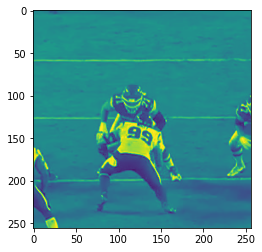

(torch.Size([26, 256, 256]),
 array([ 4.1900e+01,  2.0080e+01,  5.4000e-01,  6.0000e-02,  2.5269e+02,
         2.6231e+02,  9.2000e-01,  9.0000e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0000e+00], dtype=float32),
 0.0)

In [ ]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [ ]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
#model.load_state_dict(torch.load('/kaggle/input/nfl-exp1/resnet50_fold0.pt'))
model.load_state_dict(torch.load(data_dir + 'models/resnet50_fold0.pt'))

model.eval()
    
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.2*(output1.sigmoid().cpu().numpy()) + 0.8*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 77/77 [14:25<00:00, 11.24s/it]


In [ ]:
th = 0.29

test_filtered['contact'] = (y_pred >= th).astype('int')

#sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')
sub = pd.read_csv(data_dir + 'sample_submission.csv')
sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv(data_dir + "submission1.csv", index=False)
len(sub)
sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0
